# Multi-Agent Routing with LangGraph

This notebook demonstrates how to build a multi-agent system that directs queries to specialized language models (LLMs) based on their content. We will use LangGraph to create a stateful graph that manages the routing logic.

## Key Features of the Router

-  **Router Functionality:** Enables an LLM to select a single step from multiple options.
-  **Router Control:** Offers limited control, as the LLM makes one decision and generates specific output from predefined choices.

## Overview of Graph Structure

-  A code-specialized LLM
-  A math-specialized LLM
-  A creative-specialized LLM
-  A general-purpose LLM

## 1. Imports and State Definition

In [ ]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from rich import print
from langchain_ollama import ChatOllama, OllamaEmbeddings

load_dotenv()

In [ ]:
# Define the state structure
class AgentState(TypedDict):
    query: str
    route: str
    response: str
    reasoning: str

## 2. Mock LLM Definitions

To simulate a multi-agent environment without requiring actual API calls, we define several mock LLM functions. Each function represents a specialized agent and returns a formatted string indicating which LLM was called.

In a real-world application, these would be replaced with actual calls to different LLM APIs or models.

In [ ]:
# Mock LLM responses (replace with actual LLM calls)
def code_llm(query: str) -> str:
    """Specialized LLM for coding questions"""
    return f"[CODE LLM] Here's a programming solution for: {query}"

def math_llm(query: str) -> str:
    """Specialized LLM for math questions"""
    return f'[MATH LLM] Mathematical analysis of: {query}'

def general_llm(query: str) -> str:
    """General purpose LLM"""
    return f'[GENERAL LLM] General response to: {query}'

def creative_llm(query: str) -> str:
    """Specialized LLM for creative tasks"""
    return f'[CREATIVE LLM] Creative response to: {query}'

## 3. The Router Function

The `route_query` function is the core of our routing logic. It inspects the user's query for specific keywords to determine the most appropriate LLM. 

It uses predefined lists of keywords for different domains (code, math, creative). If a keyword is found, it sets the `route` and `reasoning` fields in the agent's state. If no specific keywords are matched, it defaults to the 'general' route.

In [37]:
import json

def route_query(state: AgentState) -> AgentState:
    """ Classify the user's query into a specific domain using an LLM.
    Fall back to heuristic parsing if the LLM response is not valid JSON."""
    
    # Extract and clean the user query from the state.
    query = state["query"].strip()

    # Initialize the LLM for classification.
    # llm = ChatOpenAI(model="gpt-4.1-nano", max_tokens=500) # Alternative OpenAI model
    llm = ChatOllama(model='llama3.2', temperature=0) # Use a local Llama 3.2 model for deterministic output

    # Define the system prompt to instruct the LLM on its role and required output format.
    system = SystemMessage(content="""
        You are a routing classifier. Given a user query, respond ONLY with one token from this set:
        code | math | creative | general
        Definitions:
        - code: programming, software engineering, APIs, debugging, algorithms.
        - math: equations, calculus, probability, statistics, numeric problem solving.
        - creative: storytelling, poems, fiction, characters, plot, imaginative writing.
        - general: anything else (explanations, science, history, general knowledge).
        If ambiguous, choose the most plausible specialized category else 'general'.
        Return a JSON object: {"route": <one of above>, "reasoning": "short explanation"}.
        Strict JSON.
        """.strip())
    # Prepare the user's query for the LLM.
    human = HumanMessage(content=f"Query: {query}")

    # Send the request to the LLM.
    raw = llm.invoke([system, human])
    
    # Normalize the LLM response to a string.
    text = raw.content if hasattr(raw, 'content') else str(raw)

    # Set default values in case parsing fails.
    route = "general"
    reasoning = "LLM routing fallback to general"
    
    # Attempt to parse the LLM's JSON output.
    try:
        data = json.loads(text)
        route = data.get("route", route)
        reasoning = data.get("reasoning", reasoning)
    # If JSON parsing fails, use a heuristic to find the route.
    except json.JSONDecodeError:
        print(f"[red]Warning:[/red] LLM routing output not valid JSON: {text[:100]}")
        lowered = text.lower()
        # Scan the output for a valid route keyword.
        for candidate in ["code", "math", "creative", "general"]:
            if candidate in lowered:
                route = candidate
                reasoning = f"Heuristic parse from LLM output: {text[:60]}" # Log the raw output for debugging
                break
                
    # Update the agent state with the routing decision.
    state["route"] = route
    state["reasoning"] = reasoning
    
    return state


## 4. Agent Nodes

Each of these functions represents a node in our graph. When the graph transitions to one of these nodes, the corresponding function is executed. Each function calls its specialized mock LLM with the query, and updates the `response` field in the state.

In [ ]:
def handle_code_query(state: AgentState) -> AgentState:
    """Process query with code-specialized LLM"""
    response = code_llm(state['query'])
    state['response'] = response
    return state

def handle_math_query(state: AgentState) -> AgentState:
    """Process query with math-specialized LLM"""
    response = math_llm(state['query'])
    state['response'] = response
    return state

def handle_creative_query(state: AgentState) -> AgentState:
    """Process query with creative-specialized LLM"""
    response = creative_llm(state['query'])
    state['response'] = response
    return state

def handle_general_query(state: AgentState) -> AgentState:
    """Process query with general LLM"""
    response = general_llm(state['query'])
    state['response'] = response
    return state

## 5. Graph Construction

Now we build the graph using `StateGraph`.

1.  **Nodes**: We add the `router` and each of the specialized handler functions as nodes in the graph.
2.  **Entry Point**: We set the `router` node as the entry point. All queries will start here.
3.  **Conditional Edges**: After the `router` node, we use `add_conditional_edges`. The `determine_next_node` function reads the `route` from the state and tells the graph which specialized node to go to next.
4.  **End Points**: After each specialized node has done its work, it transitions to the `END` state, finishing the execution for that query.
5.  **Compilation**: Finally, we compile the workflow into a runnable application.

In [38]:
def determine_next_node(state: AgentState) -> Literal['code', 'math', 'creative', 'general']:
    """Return the next node based on routing decision"""
    return state['route']

def create_routing_agent(use_llm: bool = True):
    """Create and return the LangGraph routing agent.

    Args:
        use_llm: If True and LLM available, use LLM router; otherwise keyword router.
    """

    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node('router', route_query)
    workflow.add_node('code', handle_code_query)
    workflow.add_node('math', handle_math_query)
    workflow.add_node('creative', handle_creative_query)
    workflow.add_node('general', handle_general_query)

    workflow.set_entry_point('router')

    workflow.add_conditional_edges(
        'router', determine_next_node, {'code': 'code', 'math': 'math', 'creative': 'creative', 'general': 'general'}
    )

    workflow.add_edge('code', END)
    workflow.add_edge('math', END)
    workflow.add_edge('creative', END)
    workflow.add_edge('general', END)

    return workflow.compile()

## 6. Execution and Demonstration

Below we instantiate the routing agent. If an OpenAI-compatible API key is present (OPENAI_API_KEY), the router uses an LLM to classify the query; otherwise it falls back to deterministic keyword routing. You can override the model via the `ROUTER_MODEL` environment variable. Set `use_llm=False` in `create_routing_agent` to force keyword routing.


Subgraph structure (router uses LLM = True )

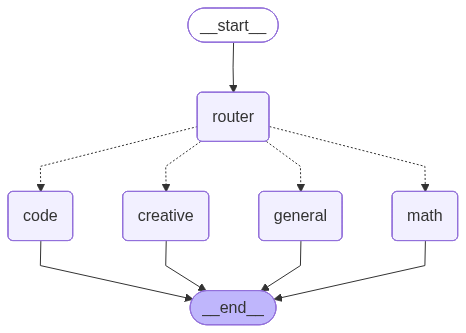

In [39]:
agent = create_routing_agent(use_llm=True)
print('Subgraph structure (router uses LLM =', bool(ChatOpenAI), ')')
# Optional: Display a visualization of the graph's structure.
try:
    from IPython.display import Image, display
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [40]:
from rich.panel import Panel
from rich.rule import Rule

test_queries = [
    'How do I implement a binary search algorithm in Python?',
    "What's the integral of 2x³ + 5x² - 3x + 7?",
    'Write a mysterious short story about a lighthouse keeper',
    'What causes the northern lights phenomenon?',
    'Help me optimize this SQL query performance',
    'Solve for x: 3x² - 12x + 9 = 0',
]

print(Panel.fit("[bold green]LangGraph LLM-Powered Routing Agent Demo[/bold green]", style="bold"))

for i, query in enumerate(test_queries, 1):
    print(Rule(f"[bold]Query {i}[/bold]", style="red"))
    print(f"[bold]Query:[/bold] [italic]{query}[/italic]\n")

    # Run the agent
    result = agent.invoke({'query': query})

    # Print results with rich formatting
    print(f"   [bold cyan]Route:[/bold cyan] [yellow]{result['route']}[/yellow]")
    print(f"   [bold cyan]Reasoning:[/bold cyan] {result['reasoning']}")
    print(f"   [bold cyan]Response:[/bold cyan] {result['response'][:100]}...")

╭──────────────────────────────────────────╮
│ LangGraph LLM-Powered Routing Agent Demo │
╰──────────────────────────────────────────╯

───────────────────────────────────────────────────── Query 1 ─────────────────────────────────────────────────────

Query: How do I implement a binary search algorithm in Python?

Warning: LLM routing output not valid JSON: ```
{"route": "code", "reasoning": "binary search is an efficient algorithm for finding an item from

Route: code

Reasoning: Heuristic parse from LLM output: ```
{"route": "code", "reasoning": "binary search is an effi

Response: [CODE LLM] Here's a programming solution for: How do I implement a binary search algorithm in 
Python...

───────────────────────────────────────────────────── Query 2 ─────────────────────────────────────────────────────

Query: What's the integral of 2x³ + 5x² - 3x + 7?

Warning: LLM routing output not valid JSON: ```
{"route": "math", "reasoning": "The query involves a mathematical operation, specifically findin

Route: math

Reasoning: Heuristic parse from LLM output: ```
{"route": "math", "reasoning": "The query involves a mat

Response: [MATH LLM] Mathematical analysis of: What's the integral of 2x³ + 5x² - 3x + 7?...

───────────────────────────────────────────────────── Query 3 ─────────────────────────────────────────────────────

Query: Write a mysterious short story about a lighthouse keeper

Route: creative

Reasoning: The query is related to storytelling, which falls under the creative category.

Response: [CREATIVE LLM] Creative response to: Write a mysterious short story about a lighthouse keeper...

───────────────────────────────────────────────────── Query 4 ─────────────────────────────────────────────────────

Query: What causes the northern lights phenomenon?

Route: general

Reasoning: The Northern Lights are a natural light display caused by charged particles from the sun interacting 
with the Earth's magnetic field and atmosphere.

Response: [GENERAL LLM] General response to: What causes the northern lights phenomenon?...

───────────────────────────────────────────────────── Query 5 ─────────────────────────────────────────────────────

Query: Help me optimize this SQL query performance

Warning: LLM routing output not valid JSON: ```
{
  "route": "code",
  "reasoning": "The query is related to programming and software engineerin

Route: code

Reasoning: Heuristic parse from LLM output: ```
{
  "route": "code",
  "reasoning": "The query is relate

Response: [CODE LLM] Here's a programming solution for: Help me optimize this SQL query performance...

───────────────────────────────────────────────────── Query 6 ─────────────────────────────────────────────────────

Query: Solve for x: 3x² - 12x + 9 = 0

Route: math

Reasoning: This is a quadratic equation, which falls under the category of math.

Response: [MATH LLM] Mathematical analysis of: Solve for x: 3x² - 12x + 9 = 0...